# **Goal: 다음 분기에 어떤 게임을 설계해야 할까**
*1. 지역에 따라서 선호하는 게임 장르가 다를까*

*2. 연도별 게임의 트렌드가 있을까*

*3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스*

# 1. 데이터 불러오기 및 전처리

In [2]:
# 데이터 불러오기
import pandas as pd

data = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(data)
df

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...,...
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [3]:
# 필요없는 0번째 컬럼 삭제
df = df.drop(df.columns[0], axis=1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [4]:
# 결측치 확인
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [5]:
# 결측치 제거
df = df.dropna().reset_index(drop = True)
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

In [ ]:
'''
for i in range(1, len(df.columns)):
  print(df.iloc[:,i].unique())
'''
# 이 셀의 실행결과, 판매량을 나타내는 4개의 열에 'K' 또는 'M'으로 단위가 축약된 데이터들이 있으므로 이것들을 원래의 숫자 형태로 바꿔주어야 데이터 조작이 용이하다.

In [7]:
# 매출액을 나타내는 컬럼에서 'K'와 'M'을 제거하여 숫자형으로 바꾼 후, 이것들이 붙어있던 곳에 각각 1000, 1000000을 곱해주는 함수를 생성
def unit_remover(column, temp_list):
  for i in range(len(column)):
    if ('K' in column[i]):
      column[i] = column[i].replace('K','')
      temp_list.append(1)
    elif ('M' in column[i]):
      column[i] = column[i].replace('M','')
      temp_list.append(2)
    else: temp_list.append(0)
  return column, temp_list

def numeric_converter(column):
  temp = []
  unit_remover(column, temp)
  column = pd.to_numeric(column)
  for i in range(len(temp)):
    if (temp[i] == 1):
      column[i] = column[i] * 1000
    elif (temp[i] == 2):
      column[i] = column[i] * (10**6)
  return column

In [8]:
# 위의 함수를 실행하여 기존 df에 저장
for i in range(5, len(df.columns)):
  df.iloc[:,i] = numeric_converter(df.iloc[:,i].copy())
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

In [9]:
# 연도 컬럼에서 4자리 수가 아닌 값을 4자리로 바꿔주는 함수 생성
def year_converter(column):
  for i in range(len(column)):
    if (column[i] <= 21):
      column[i] += 2000
    elif (21 < column[i] <= 99):
      column[i] += 1900
  return column

In [10]:
# 연도의 값을 모두 4자리로 변경
df['Year'] = year_converter(df['Year'].copy())
df['Year'].unique()

array([2008., 2009., 2010., 2005., 2011., 2007., 2001., 2003., 2006.,
       2014., 2015., 2002., 1997., 2013., 1996., 2004., 2000., 1984.,
       1998., 2016., 1985., 1999., 1995., 1993., 2012., 1987., 1982.,
       1994., 1990., 1992., 1991., 1983., 1988., 1981., 1989., 1986.,
       2017., 1980., 2020.])

In [11]:
# 4 지역에 대한 출고량을 합한 전체 출고량 컬럼 생성
df['Sales_Sum'] = df.iloc[:,5:].sum(axis=1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_Sum
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


In [ ]:
'''1차 전처리 완료'''

# 2. '지역에 따라서 선호하는 게임 장르가 다를까?'에 대한 답 찾기

In [12]:
# 지역과 장르를 변수로 하여 ANOVA 수행
# anova를 수행할 수 있는 형태로 df를 변환

tidy1 = df.melt(id_vars='Genre', value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
tidy1.rename(columns = {'variable':'Region', 'value':'Sales'}, inplace=True)
tidy1

,Genre,Region,Sales
0,Action,NA_Sales,0.04
1,Action,NA_Sales,0.17
2,Adventure,NA_Sales,0.00
3,Misc,NA_Sales,0.04
4,Platform,NA_Sales,0.12
...,...,...,...
64959,Platform,Other_Sales,0.01
64960,Action,Other_Sales,0.00
64961,Sports,Other_Sales,0.13
64962,Action,Other_Sales,0.03


In [13]:
# anova 수행
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula1 = 'Sales ~ C(Genre) + C(Region) + C(Genre):C(Region)'
lm1 = ols(formula1, tidy1).fit()
print(anova_lm(lm1))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                         df        sum_sq  ...          F        PR(>F)
C(Genre)               11.0  7.324384e+10  ...   1.330774  1.996826e-01
C(Region)               3.0  1.570708e+11  ...  10.464054  7.053486e-07
C(Genre):C(Region)     33.0  2.182676e+11  ...   1.321908  1.022860e-01
Residual            64916.0  3.248075e+14  ...        NaN           NaN

[4 rows x 5 columns]


In [ ]:
'''
장르에 대해서는 p-value가 0.200으로 0.05보다 크므로, 장르에 따른 매출액은 차이가 없다고 볼 수 있는 가능성이 그렇지 않은 것보다 높다.
지역에 대해서는 p-value가 0.000으로 0.05보다 작으므로, 지역에 따른 매출액은 차이가 있다고 볼 수 있는 가능성이 높다.
장르와 지역의 교호작용에 대해서는 p-value가 0.102로 0.05보다 크므로, 두 변수가 서로에게 미치는 영향은 없다고 볼 수 있는 가능성이 높다.
즉, 유의수준 5%에서는 지역에 따라서 선호하는 게임 장르에 차이가 없을 가능성이 높다고 할 수 있다.
'''

# 3. '연도별 게임의 트렌드가 있을까'에 대한 답 찾기

In [14]:
# 연도별 각 장르에 해당하는 게임이 얼마나 출시되었는가에 대한 df 생성

wide1 = pd.crosstab(df['Genre'], df['Year'])
wide1

Year,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2020.0
Genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,1,25,18,7,1,2,6,2,2,2,3,5,1,6,4,8,20,31,44,39,43,66,125,144,125,192,184,210,219,271,226,239,263,148,186,253,118,1,0
Adventure,0,0,0,1,0,0,0,1,0,0,0,2,4,1,4,13,17,14,23,19,16,20,41,12,38,42,71,84,166,141,153,107,57,60,75,53,33,0,0
Fighting,1,0,0,0,0,1,0,2,0,0,0,1,7,11,22,29,30,28,41,24,29,18,54,44,39,43,55,50,57,53,40,49,29,20,23,21,14,0,0
Misc,4,0,1,1,1,0,0,0,0,1,0,1,2,3,6,22,23,12,21,25,20,26,45,53,67,110,109,150,210,207,200,183,38,42,41,39,18,0,0
Platform,0,3,5,5,1,4,6,2,4,3,3,6,6,11,11,13,14,18,25,18,24,43,77,87,66,82,54,42,62,28,31,37,11,37,10,14,10,0,0
Puzzle,0,2,3,1,3,4,0,0,1,5,2,4,5,3,3,12,9,14,13,6,12,15,20,7,25,32,42,65,64,79,45,43,11,3,7,6,0,0,0
Racing,0,1,2,0,3,0,1,0,1,0,2,1,2,2,8,12,21,36,48,49,43,71,103,109,70,77,75,84,82,83,57,64,30,16,27,19,20,0,0
Role-Playing,0,0,0,0,0,0,1,3,3,2,2,5,5,9,17,24,28,23,26,32,29,41,54,48,60,71,108,103,112,103,103,95,78,70,90,78,40,2,0
Shooter,2,10,5,1,3,1,4,2,1,1,0,3,3,2,11,29,23,27,23,16,20,36,78,73,88,96,69,84,83,91,81,94,48,59,47,34,32,0,0


In [15]:
# 카이제곱 검정 수행
from scipy.stats import chi2_contingency
chi2, pv, dof, ex = chi2_contingency(wide1, correction = False)
print('카이제곱 =', chi2, 'p-value =', pv)

카이제곱 = 2763.3426220442343 p-value = 0.0


In [ ]:
'''
p-value가 0이므로 장르와 연도는 서로 종속적일 가능성이 높다.
'''

In [16]:
# 5년 단위의 heatmap을 그리기 위한 df 생성

vis_df1 = pd.DataFrame(wide1.iloc[:,0*5:(0+1)*5].sum(axis=1))

for i in range(1,len(wide1.columns)//5 + 1):
  vis_df1.loc[:,i] = wide1.iloc[:,(i)*5:(i+1)*5].sum(axis=1)
vis_df1.columns = ['1980 ~ 1984', '1985 ~ 1989', '1990 ~ 1994', '1995 ~ 1999', '2000 ~ 2004', '2004 ~ 2009', '2010 ~ 2014', '2015 ~ ']
vis_df1

,1980 ~ 1984,1985 ~ 1989,1990 ~ 1994,1995 ~ 1999,2000 ~ 2004,2004 ~ 2009,2010 ~ 2014,2015 ~
Genre,,,,,,,,
Action,52,14,19,142,503,1076,1062,372
Adventure,1,1,11,86,127,504,452,86
Fighting,1,3,41,152,184,258,161,35
Misc,7,1,12,103,211,786,504,57
Platform,14,19,37,88,297,268,126,24
Puzzle,9,10,17,54,79,282,109,6
Racing,6,2,15,166,396,401,194,39
Role-Playing,0,9,38,133,232,497,436,120
Shooter,21,9,19,118,295,423,329,66


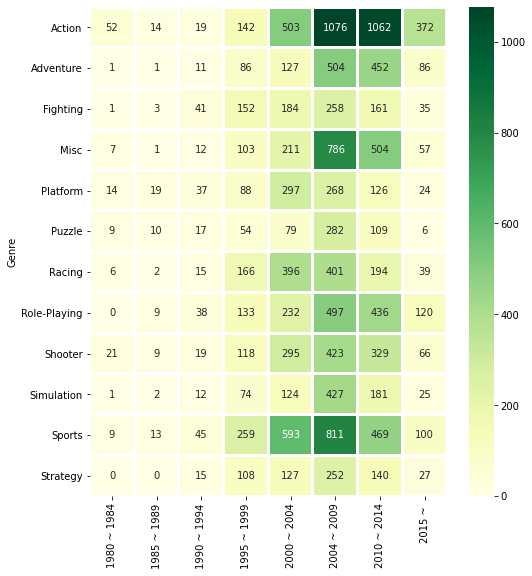

In [17]:
# heatmap 그려보기
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,9))
sns.heatmap(vis_df1, cmap='YlGn', annot=True, fmt='d', linewidths=2)

In [18]:
# 1980~1995는 출고량이 적으므로 제외, 2017년 부터는 제대로 집계되지 않았기에 제외하고 3년 단위로 heatmap을 그리기 위한 df 생성
vis_df2 = pd.DataFrame(wide1.iloc[:,16:16+(1)*3].sum(axis=1))

for i in range(1,7):
  vis_df2.loc[:,i] = wide1.iloc[:,16+(i)*3:16+(i+1)*3].sum(axis=1)
vis_df2.columns = ['1996 ~ 1998', '1999 ~ 2001', '2002 ~ 2004', '2005 ~ 2007', '2008 ~ 2010', '2011 ~ 2013', '2014 ~ 2016']
vis_df2

,1996 ~ 1998,1999 ~ 2001,2002 ~ 2004,2005 ~ 2007,2008 ~ 2010,2011 ~ 2013,2014 ~ 2016
Genre,,,,,,,
Action,95,148,394,586,716,650,557
Adventure,54,55,91,197,460,224,161
Fighting,99,71,137,148,150,98,58
Misc,56,71,165,369,617,263,98
Platform,57,85,230,178,121,85,34
Puzzle,36,33,52,139,188,57,13
Racing,105,163,282,236,222,110,66
Role-Playing,77,102,162,282,318,243,208
Shooter,73,72,239,249,255,201,113


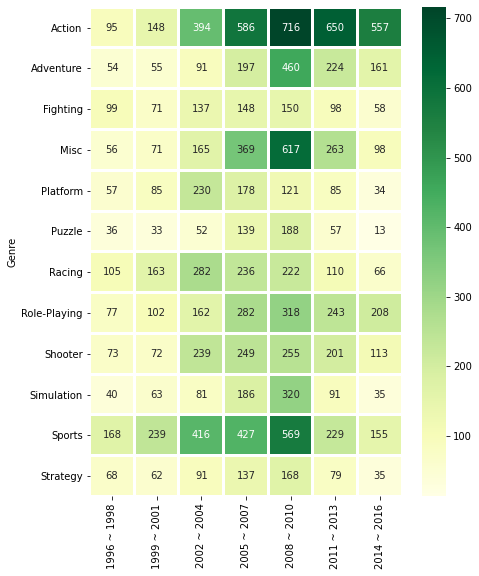

In [19]:
# heatmap 그려보기
plt.figure(figsize=(7,9))
sns.heatmap(vis_df2, cmap='YlGn', annot=True, fmt='d', linewidths=2)

# 4. '출고량이 높은 게임에 대한 분석 및 시각화 프로세스'에 대한 답 찾기

In [24]:
# 2012~2016년 사이에 전체 출고량이 많았던 게임 50가지 뽑아내기
con1 = df[(df['Year'] >= 2012) & (df['Year'] <= 2016)]
top_50 = con1.sort_values(by='Sales_Sum', ascending=False).head(50)
top_50

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_Sum
10695,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9630000.00,5.31,0.06,1.38,9630006.75
7708,FIFA 14,X360,2013.0,Sports,Electronic Arts,0.92,2930000.00,0.01,0.46,2930001.39
1601,Assassin's Creed III,PS3,2012.0,Action,Ubisoft,2.64,2560000.00,0.16,1.14,2560003.94
9602,Call of Duty: Ghosts,PS4,2013.0,Shooter,Activision,1780000.00,1.42,0.05,0.38,1780001.85
14984,Call of Duty: Advanced Warfare,XOne,2014.0,Shooter,Activision,3.21,1530000.00,0.01,0.38,1530003.60
3929,Uncharted 4: A Thief's End,PS4,2016.0,Shooter,Sony Computer Entertainment,1300000.00,2.07,0.18,0.65,1300002.90
5183,Forza Motorsport 5,XOne,2013.0,Racing,Microsoft Game Studios,1210000.00,0.78,0.01,0.17,1210000.96
7558,Super Mario Maker,WiiU,2015.0,Platform,Nintendo,1180000.00,0.87,0.93,0.20,1180002.00
6880,StarCraft II: Heart of the Swarm,PC,2013.0,Strategy,Activision,820000.00,0.65,0.00,190000.00,1010000.65
13936,WWE '13,X360,2012.0,Action,THQ,720000.00,0.45,0.00,0.11,720000.56


In [27]:
# 각 컬럼에서 관측되는 데이터별로 횟수 확인
print(top_50['Platform'].value_counts(sort=False), '\n', top_50['Year'].value_counts(sort=False), '\n', top_50['Genre'].value_counts(sort=False))

PS4      7
PSV      2
PC       2
PSP      1
Wii      2
X360     7
PS3     14
DS       3
XOne     4
3DS      6
WiiU     2
Name: Platform, dtype: int64 
 2013.0    20
2012.0    15
2014.0     6
2016.0     2
2015.0     7
Name: Year, dtype: int64 
 Strategy         1
Shooter          6
Platform         4
Sports           6
Misc             2
Racing           3
Fighting         4
Role-Playing     8
Action          16
Name: Genre, dtype: int64


In [28]:
# 2012~2016 기간동안 전체 출고량 상위 50위 게임들이 각 지역별로 얼마나 출고되었는지 확인
top_50.iloc[:,5:9].sum()

NA_Sales       20380017.98
EU_Sales        9790024.18
JP_Sales        1110003.09
Other_Sales     1800008.25
dtype: float64

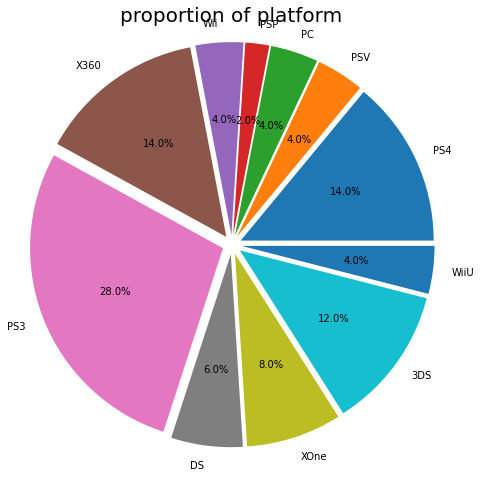

In [32]:
# 출고량 상위 50개의 게임들은 어떤 플랫폼을 많이 이용하고 있는지 그려보기
label1 = ['PS4', 'PSV', 'PC', 'PSP', 'Wii', 'X360', 'PS3', 'DS', 'XOne', '3DS', 'WiiU']
explode1 = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
plt.figure(figsize=(8,8))
plt.pie(top_50['Platform'].value_counts(sort=False), 
        labels=label1, autopct='%1.1f%%',
        explode=explode1)
plt.title('proportion of platform', fontsize=20)
plt.axis('equal')
plt.show()

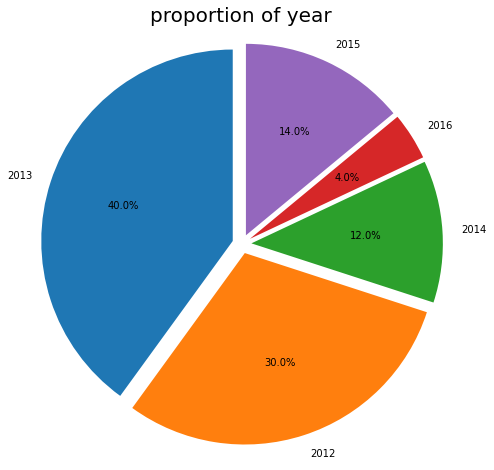

In [33]:
# 출고량 상위 50개의 게임들이 어느 해에 많이 출시되었나 그려보기
label2 = ['2013', '2012', '2014', '2016', '2015']
explode1 = (0.05, 0.05, 0.05, 0.05, 0.05)
plt.figure(figsize=(8,8))
plt.pie(top_50['Year'].value_counts(sort=False), 
        labels=label2, autopct='%1.1f%%',
        explode=explode1, startangle=90)
plt.title('proportion of year', fontsize=20)
plt.axis('equal')
plt.show()

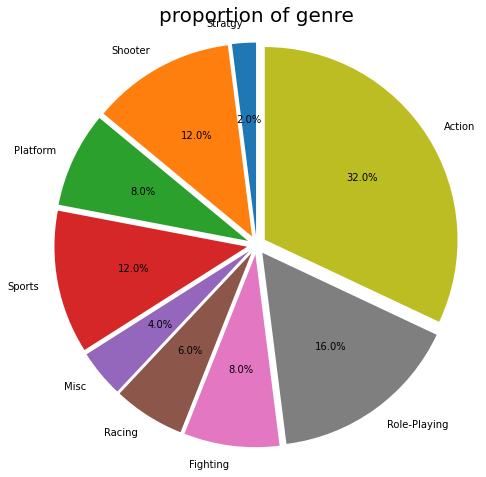

In [35]:
# 출고량 상위 50개의 게임들은 어떤 장르에 많이 속해있는지 그려보기
label3 = ['Stratgy', 'Shooter', 'Platform', 'Sports', 'Misc', 'Racing', 'Fighting', 'Role-Playing', 'Action']
explode1 = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
plt.figure(figsize=(8,8))
plt.pie(top_50['Genre'].value_counts(sort=False), 
        labels=label3, autopct='%1.1f%%',
        explode=explode1, startangle=90)
plt.title('proportion of genre', fontsize=20)
plt.axis('equal')
plt.show()

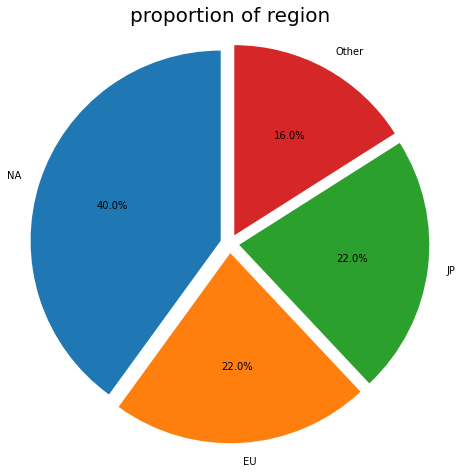

In [36]:
# 출고량 상위 50개의 게임들은 어느 지역에서 가장 인기가 많았는지 그려보기
value = [20, 11, 11, 8]
label1 = ['NA', 'EU', 'JP', 'Other']
explode1 = (0.05, 0.05, 0.05, 0.05)
plt.figure(figsize=(8,8))
plt.pie(value, 
        labels=label1, autopct='%1.1f%%',
        explode=explode1, startangle=90)
plt.title('proportion of region', fontsize=20)
plt.axis('equal')
plt.show()